saw some cool ants, and I wanted to make something that looked like them :)

here's what we'll do, each time an ant goes somewhere it leaves a scent. that scent has a time decay period. when an ant finds sugar, it'll pick it up. but we also want to drive variability right? also this is only useful based on the belief that the sugar clusters. which it should! to some degree. we want the ant to random walk over weighted probabilities. 

oh you know what? the ant needs an orientation. and it costs the ant a turn to rotate. i saw this observing the ants! how about have ants weight their direction to be forwards rather than backwards?

i think the return behavior actually matters because it reinforces the algo. so, ant has an explore mode and a return mode?

ok how about when an ant finds food it drops a second kind of pheromone, a "local search" pheromone that says hey i found food here, look around locally. it has the ant strongly pull away from the food square after it has just been on it. 

can ants stack? yes but only two per square. 
what happens when it hits sugar? it follows it back? 

maybe the ant has a desire not to backtrack? so it 

so, we'll build a class that generates the sugar field, and passes it to ant hive that initializes. We'll use gaussian random fields to populate the grid with a GRF and then draw binary sugar presence / absence from it. 


In [1]:
import numpy as np
from FyeldGenerator import generate_field
import scipy.stats as st
import matplotlib.pyplot as plt
import json
import copy
import random
from matplotlib.colors import LinearSegmentedColormap

In [2]:
class SugarField:

    def __init__(self, grid_size=(100,100), grf_shape_param= 7, grf_damper=1, grid_type='grf'):
        """

        grid_size: 2D tuple defining size of grid life is playing on
        """
        self.grf_shape_param = grf_shape_param
        self.grf_damper = grf_damper
        self.grid_size = grid_size
        self.grid_l = grid_size[0] # up / down
        self.grid_w = grid_size[1] 
        self.gen_sugar_field(grid_type=grid_type)


    def gen_sugar_field(self, grid_type):
        np.random.seed(42069)
        if grid_type == 'uniform_rand':
            p_ones = 0.4
            self.grid = np.random.choice([0,1], self.grid_size, p=((1-p_ones),p_ones)) # seed random start 
        if grid_type == 'grf':
            self.gen_corr_probability_field() # creates self.grid_init_prob_field
            self.grid = np.random.binomial(n=1, p=self.grid_init_prob_field, size=self.grid_size)
        # something to add: a situation where a gaussian random field sets the seed probability as a function of space!


    def gen_corr_probability_field(self):
        """
        uses random fields to generate a spatially correlated field of bernoulli probabilities, one probability per grid cell, 
        which we'll use to draw an initial grid of 1s and 0s for conway's game
        """
        def Pkgen(n):
            def Pk(k):
                return np.power(k, -n)
        
            return Pk
        
        
        # Draw samples from a normal distribution
        def distrib(shape):
            a = np.random.normal(loc=0, scale=1, size=shape)
            b = np.random.normal(loc=0, scale=1, size=shape)
            return a + 1j * b
        
        
        shape = (self.grid_l, self.grid_w)
        
        field = generate_field(distrib, Pkgen(self.grf_shape_param), shape) # 7 just because I like the grouping effect
        z_field = (field-np.mean(field))/np.std(field)
        prob_field= st.norm.cdf(z_field) / self.grf_damper #grf dampener is because my probability field was too high; too much sugar! 
        self.grid_init_prob_field = prob_field

    def plot_field(self):
        plt.imshow(self.grid, cmap='binary', interpolation='nearest')
        


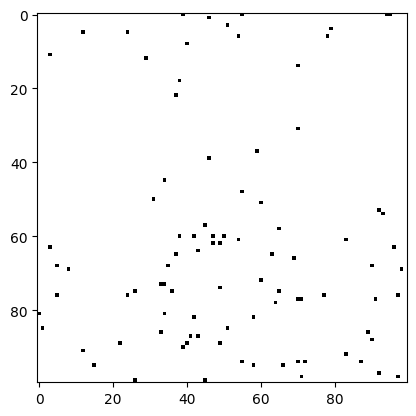

In [3]:
sf= SugarField(grf_shape_param=30, grf_damper=50)
sf.plot_field()

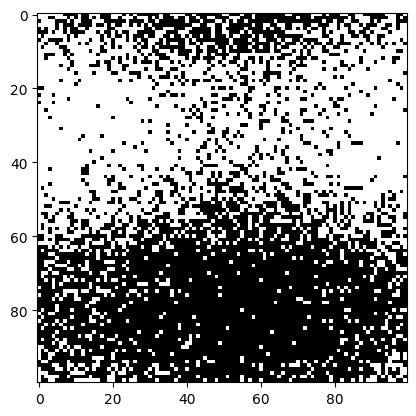

In [4]:
sf= SugarField(grf_shape_param=30, grf_damper=1)
sf.plot_field()

In [5]:
sf.grid[0,90:99] # observe: going "west to east" means increasing the second index

array([1, 1, 1, 1, 0, 0, 0, 1, 1])

In [6]:
sf.grid[90:99,0] # likewise going "north to south" means increasing the first index

array([0, 0, 0, 0, 1, 1, 0, 0, 0])

In [295]:
# going to build separate ant and hive objects
# heh could even have the hive try to coordinate among multiple sugar fields in parallel and have it cost something to generate an ant at one field
# let ants stack for now

class AntMindOld:
    
    def __init__(self, ant_orientation):
        """

        ant_orientation: where the ant is pointed. equivalent to the ant's previous move (ant only points where it moves). probabilities
        are 
        """
        self.has_sugar = 0 # do we have it currently?
        self.picked_up_sugar_this_turn = 0 # did we pick it up this turn?
        #self.local_grid = local_grid
        self.orientation = ant_orientation

        self.moveset = []
        #self.moveset.append(self.orientation) # where it came from!

        #note: going "west to east" means increasing the second index, likewise going "north to south" means increasing the first index
        self.flip_orientation_dict ={'[0, 0]':[2,2],'[0, 1]':[2,1],'[0, 2]':[2,0],'[1, 0]':[1,2], '[1, 2]':[1,0], '[2, 0]':[0,2], '[2, 2]':[0,0], '[2, 1]':[0,1]}

        
    def move_ant(self, local_grid):
        """
        local_grid: pass the ant a local grid consisting of where it is and the grid squares around there, including any objects
            in the local grid (objects such as pheromones or sugar). we'll also update the local grid and then pass it back out. 
            local grid is a dict of grids actually. one grid is the pheromone grid. since the grid is 3x3 numpy array, the ant
            itself is located at indices [1,1]
        """
        self.local_grid = local_grid
        self.local_grid_in = copy.deepcopy(local_grid)
        self.drop_pheromone()

        if self.has_sugar:
            # if the ant already has sugar, keep sending it home!
            self.step_home()

        elif self.local_grid['sugar'][1,1] == 1: # on sugar!
            self.pick_up_sugar()


        else:
            self.step_forward()

        # have the HiveMind object then pull the following: self.next_move, self.local_grid
        # then HiveMind has to update the relative grid with the current local grid, and move the ant!

        # TODO: note that right now neither these nor the local pheromone update matter; we are directly updating in WorldMind
        # in the future it'd be nice to use these instead but you have to update the grids before moving the ant both
        # in the ant object and the mind object; 
        self.pher_update = self.local_grid['pher'] - self.local_grid_in['pher']
        self.sugar_update = self.local_grid['sugar'] - self.local_grid_in['sugar']
        self.delta_grid = {'sugar':self.sugar_update, 'pher':self.pher_update}

    def pick_up_sugar(self):
        self.has_sugar = 1 # pick it up
        self.local_grid['sugar'][1,1] = 0 # sugar no longer on the grid
        self.step_home() # begin walking home, also this ensures we always have a self.next_move because we need it; the world object uses this to move!

        self.picked_up_sugar_this_turn = 1 # note you picked up up this turn
        # note that self.step_home() command needs to shut picked up sugar this turn off but then we turn it back on

    def step_forward(self):
        
        self.gen_weights() # generate the weights for moving forward
        self.get_next_move()
        self.orientation = self.next_move # going to return the next move as well as updated grid to the grid coordinator; ant updates orientation before moving
        self.moveset.append(self.orientation) # only append last move to moveset when moving forward


    def gen_weights(self):

        
        """
        we generate a set of weights that add to 1, assigned to each element of the grid (zeroed out for the center element)
        from these weights we'll draw a new direction to move in
        we set a greater weight to the direction we're pointed in
        """

        weight_unit = 50
        
        weights = np.zeros([3,3])
        weights[self.orientation[0],self.orientation[1]] += weight_unit # add 1 to currently pointed direction

        # cool little algo to get the indices of the two "neighboring" directions to our currently pointed direction
        # e.g. if we were pointed south we'd want southwest and southeast
        # basically we joystick up, down, left, and right, and throw it out if we hit the center or go off the 3x3
        potential_neighbors = [[self.orientation[0]+1,self.orientation[1]],[self.orientation[0]-1,self.orientation[1]],[self.orientation[0],self.orientation[1]+1],[self.orientation[0],self.orientation[1]-1]]
        neighbors = [el for el in potential_neighbors if (el!=[1,1] and el[0]>= 0 and el[0]<=2 and el[1]>=0 and el[1]<=2)] 

        weights[neighbors[0][0],neighbors[0][1]]+= weight_unit / 2
        weights[neighbors[1][0],neighbors[1][1]]+= weight_unit / 2

        weights = weights + self.local_grid['pher'] # add pheromone values directly to weights; note they're in same units!

        weights[1,1] = 0 # no need to regard weight on current location

        # drop weight to 0 for any wall locations

        weights = np.multiply(weights, 1-self.local_grid['wall'])

        # don't go back the way we came
        last_position = self.flip_orientation(self.orientation) # get the coords for the direction we came back from
        weights[last_position[0], last_position[1]] = 0 # set the probabilities of moving to those coords to 0

        # note: we hit an edge case where things get stuck (all weights are 0). if this is ever the case, go back!
        if np.sum(weights) == 0:
            weights[last_position[0], last_position[1]] = 1 # set the probabilities of moving to those coords to 0

        self.weights = weights / np.sum(weights) # normalize weights

    def get_next_move(self):

        flat_weights = self.weights.flatten() # flatten the weights
        selected_flat_idx = np.random.choice(len(flat_weights), p=flat_weights) # select, based on weights which are probabilities, a direction
        selected_idx = np.unravel_index(selected_flat_idx, np.shape(self.weights)) # put that direction back into our 3x3 coords
        self.next_move = list(selected_idx)
        

    def step_home(self):
        """for now we'll just have the ant retrace its steps exactly to get home!"""
        self.picked_up_sugar_this_turn = 0 # sub optimal engineering means you need to make sure this switch gets off each time he steps home
        last_move = self.moveset.pop()
        self.next_move = self.flip_orientation(last_move) # reverse
        self.orientation = self.next_move
        
        
    
    
    def flip_orientation(self, orientation):
        
        # self.flip_orientation_dict ={'[0,0]':[2,2],'[0,1]':[2,1],'[0,2]':[2,0],'[1,0]':[1,2], '[1,2]':[1,0], '[2,0]':[0,2], '[2,2]':[0,0]}
        # update dict turns whatever cardinal direction we're pointing in and returns the flip
        # imagine a 3x3 grid standing for the compass, so north is at [0,1] and south is at [2,1]; so if we input N we return S
        # just needed to define it once so moved it to init, left it here for clarity
        
        orientation = self.flip_orientation_dict[str(orientation)] 
        return orientation

    def drop_pheromone(self):
        self.local_grid['pher'][1,1] += 1 #local_grid is a dict


    
        
        

In [102]:
"""
test our ant class; pass it a dummy grid and let it make a move, and see if it updates local grid, stores the move, and updates orientation
"""

test_pher = np.zeros([3,3])
test_pher[0,1] = 1
test_pher[2,2]=0.5
test_wall = np.zeros([3,3])
test_wall[0,1] = 1
test_sugar = np.zeros([3,3])
test_grid = {'pher':test_pher, 'sugar':test_sugar, 'wall':test_wall}
test_ant = AntMind([0,1])
test_ant.move_ant(test_grid) 

In [103]:
test_ant.local_grid['pher']

array([[0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 0.5]])

In [104]:
test_ant.pher_update

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [10]:
test_ant.local_grid['wall']

array([[0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [11]:
test_ant.local_grid['sugar']

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [12]:
test_ant.moveset

[[0, 2]]

In [13]:
test_ant.orientation

[0, 2]

In [14]:
test_ant.weights

array([[0.4950495 , 0.        , 0.4950495 ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00990099]])

In [308]:
class WorldMindOld:
    """
    The WorldMind object takes in the sugar field, initializes ants, and handles interactions between the ant (and it's local knowledge)
    and the global world
    """

    def __init__(self, sugar_field, home_coords = [40,40], spawn_param=0.5, max_ants = 100):

        """
        sugar_field: object of SugarField class
        init_ants: list of dicts, each dict has keys global_coord and orientation to initialize a single AntMind object with
        """
        np.random.seed(9890)
        random.seed(4829)
        self.turn_number = 0
        self.sf = copy.deepcopy(sugar_field) # 1s and 0s
        self.global_grid = {} # convert sugar field to absolute grid, which is a dict with two arrays and keys sugar and pher
        self.global_grid['sugar'] = self.sf # set sugar field
        self.global_grid['pher'] = np.zeros(np.shape(self.sf)) # initialize empty pheromone field

        # introducing "wall field"; basically we make the boundary impermeable; since our local grid is 3x3 we just set the borders to wall
        # grid 
        self.grid_size_0 = np.shape(self.sf)[0]
        self.grid_size_1 = np.shape(self.sf)[1]

        self.global_grid['wall'] = np.zeros(np.shape(self.sf)) # initialize empty wall field field
        self.global_grid['wall'][0:self.grid_size_0, 0] = 1
        self.global_grid['wall'][0:self.grid_size_0, self.grid_size_1-1] = 1
        self.global_grid['wall'][0, 0:self.grid_size_1] = 1
        self.global_grid['wall'][self.grid_size_0-1, 0:self.grid_size_1] = 1


        
        self.home_coords = home_coords

        self.sugar_score = 0 # colony's total amount of accrued sugar

        
        self.ants = [] # list of active ants

        # params used to manage ant spawn rate (rate at which ants emerge from the colony)
        #self.spawn_default_rate = spawn_default_rate 
        self.spawn_param = spawn_param # poisson parameter for new ant spawn rate
        self.max_ants = max_ants # maximum number of ants in the game
        #self.spawn_ants(init_ants_dict)
        #self.spawn_ants_old(init_ants) # what do the ants need? each ant needs an initial coordinate and an initialized mind

    def spawn_ants(self):
        """
        here's how ant spawning will work! we'll randomly spawn based on a poisson process. For now we spawn ants until we hit a max.
        Later it would be cool to have the spawn rate vary by turn, depending on how much sugar is being collected now.
        Could do this by having a rate that spikes when sugar score goes up and then decays back to some baseline rate (by making
        the rate a max of some min rate and the decaying rate). But I think for this mechanic to make sense we need to make
        sure ants can disappear as well as spawn. Maybe when an ant returns home it could have a don't come back out probability.
        """
        num_ants = len(self.ants)
        if num_ants < self.max_ants:
            num_new_ants = np.random.poisson(self.spawn_param)
            num_new_ants = np.min((num_new_ants, self.max_ants - num_ants)) # ensures we don't make more ants than the max possible
        
            for i in range(num_new_ants):
                ant_coord = self.home_coords
                ant_orientation = random.choice([[0,0],[0,1],[0,2],[1,0],[1,2],[2,0],[2,1],[2,2]]) # randomly select a valid orientation
                ant_mind = AntMindOld(ant_orientation)
                #ant = {'global_coord':ant_coord, 'mind':ant_mind, 'diagnostic':[ant_coord, [], []]}
                ant = {'global_coord':ant_coord, 'mind':ant_mind}

                self.ants.append(ant)

        

    
    def spawn_ants_old(self, init_ants):
        self.ants = []
        for init_ant in init_ants:
            ant_coord = init_ant['global_coord']
            ant_mind = AntMind(init_ant['orientation'])
            ant = {'global_coord':ant_coord, 'mind':ant_mind}
            self.ants.append(ant)
            
            
    
    def next_turn(self):
        self.turn_number += 1
        self.decay_pheromones()
        self.spawn_ants()
        self.move_ants()
        

    def decay_pheromones(self):
        self.half_life = 10 # good param to play with alongside weight param
        decay_rate = np.log(2) / self.half_life
        self.global_grid['pher'] = self.global_grid['pher']*np.exp(-1.0*decay_rate)

    def move_ants(self):

        for ant in self.ants:
            self.update_ant_and_grid(ant) 
    

    def update_ant_and_grid(self, ant):
        """
        each ant's state includes the ant object as well as its coordinates
        to run the loop on the ant we need to use its coordinates to query the global grid (sugar_field)
        """
        ant_mind = ant['mind']
        ant_coord = ant['global_coord']

        # if ant has sugar and has returned home, let it drop sugar. need to do this before moving b/c moveset will be empty
        self.update_sugar(ant)


        ant_local_grid = self.get_local_grid_from_coord(ant_coord)


        self.update_global_grid_due_to_ant(ant) # drop pheromone and possibly pick up sugar irl using old coords
        ant_mind.move_ant(ant_local_grid) # tells you where the ant is moving and whether it got sugar
        self.update_ant_location(ant, ant_mind.next_move) # update ant's coordinates irl


        
        # TODO: what order do we update the global grid in? OR how do we make updates additive? 
        
        
        # idea is to set self.new_grid = self.global_grid return the "delta grid" for each ant, add them all to self.new_grid, THEN set self.global_grid = self.new_grid
        # ok this almost will work, but what if multiple ants pick up the sugar? that doesn't work. so we want the sugar to update directly
        # to the global grid, so if one ant picks it up another cannot. but the pheromones we want to update once per turn, so that 
        # one ant's pheromone update earlier in the loop doesn't affect the next ant's update later in the loop

        #TODO: I'm doing this wrong. pheromone decay should happen in the world, not for each ant. and the world should simply
        # note an added pheromone point for the ant and possibly a sugar pickup

        
        return

    def update_sugar(self, ant):
        if (ant['mind'].has_sugar == 1) and (ant['global_coord']==self.home_coords):
            ant['mind'].has_sugar = 0
            self.sugar_score += 1
        return
        
    def get_local_grid_from_coord(self, coord):
        """takes in a coordinate for the global grid and returns the 3x3 local grid that the ant needs"""

        i = coord[0] 
        j = coord[1]
        ant_grid = {}
        ant_grid['pher'] = self.global_grid['pher'][i-1:i+2, j-1:j+2]
        ant_grid['sugar'] = self.global_grid['sugar'][i-1:i+2, j-1:j+2]
        ant_grid['wall'] = self.global_grid['wall'][i-1:i+2, j-1:j+2]
        return ant_grid

    def update_global_grid_due_to_ant(self, ant):

        # TODO: use the ant's own pher_update and sugar_update mechanisms to update
        # however right now this is easier because the ruleset for adding sugar and phers is simple and easy to append directly
        self.global_grid['pher'][ant['global_coord'][0],ant['global_coord'][1]] += 1 # add pheromones
        if ant['mind'].picked_up_sugar_this_turn:
            self.global_grid['sugar'][ant['global_coord'][0], ant['global_coord'][1]] = 0 # set sugar to 0
        
    def update_ant_location(self, ant, next_move):
        """
        using the next_move value which is like a cardinal direction e.g. [0,0] for northwest, update the ant's location. handle edge cases
        """
        additive_move = [el - 1 for el in next_move] # sets it so NW move is -1,-1 instead of 0,0; now we can just add it 
        ant['global_coord'] = [sum(x) for x in zip(ant['global_coord'], additive_move)] # does pairwise addition for elements of lists
        #ant['diagnostic'].append([ant['global_coord'], copy.deepcopy(ant['mind'].moveset), ant['mind'].next_move])

    def hive_plots(self):

        self.hive_megaplot()


        self.get_ant_grid()
        plt.figure(figsize=(5, 5))
        plt.imshow(self.ant_grid, cmap='Reds', alpha=0.9)
        plt.imshow(self.global_grid['pher']>0, cmap='grey', alpha=0.3) # ant's been here component
        plt.title('Ant Past and Present Plot') 

        plt.figure(figsize=(5, 5))
        plt.imshow(self.global_grid['sugar'])
        plt.title('Sugar Plot')
        
        plt.figure(figsize=(5, 5))
        plt.imshow(self.global_grid['pher'])
        plt.title('Pher Plot')

        #plt.figure(figsize=(5, 5))
        #plt.imshow(self.global_grid['pher']>0)
        #plt.title('Ants Been Here Plot')

        


  


        print("Turn Number: " + str(self.turn_number))
        print("Number of Ants: " + str(len(self.ants)))
        print("Sugar Score: " + str(self.sugar_score))
        
    def hive_megaplot(self):
        self.get_ant_grid()
        
        plt.figure(figsize=(5, 5))
        plt.imshow(self.ant_grid, cmap='Blues')
        plt.imshow(self.global_grid['sugar'], cmap='grey', alpha=0.3)
        plt.imshow(self.global_grid['pher'], cmap='Reds', alpha=0.8)



    
    def hive_megaplot2(self):
        grid = self.global_grid
        
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(grid['sugar'], cmap='gray', vmin=0, vmax=1, alpha=1)
        #ax.imshow(grid['pher'], cmap='magma', vmin=0, vmax=1, alpha=0.2)
        #score_image = ax.imshow(grid['pher'], cmap='magma', vmin=grid['pher'].min(), vmax=grid['pher'].max(), alpha=0.3)
        score_image = ax.imshow(grid['pher'], cmap='hot', vmin=grid['pher'].min(), vmax=grid['pher'].max(), alpha=0.7)
        cbar = plt.colorbar(score_image, ax=ax, orientation='vertical')
        cbar.set_label('pher')
        plt.show()

    def next_k_turns(self, k):
        for i in range(500):
            self.next_turn()

    def get_ant_grid(self):
        
        self.ant_grid = np.zeros([self.grid_size_0,self.grid_size_1])
        for ant in self.ants:
            coord = ant['global_coord']
            self.ant_grid[coord[0], coord[1]]+=1


In [309]:
# going to build separate ant and hive objects
# heh could even have the hive try to coordinate among multiple sugar fields in parallel and have it cost something to generate an ant at one field
# let ants stack for now

class AntMind:
    
    def __init__(self, ant_orientation, movement_weight = 50, regular_pher = 2, sugar_pher = 5):
        """

        ant_orientation: where the ant is pointed. equivalent to the ant's previous move (ant only points where it moves). probabilities
        are 

        movement_weight: the default weight we associated with movement probabilities. it's a balance of this weight and the pheromones
            that determine how much the ant will random walk forwards and to the sides vs. follow a previous pheromone trail. 
            look at the "gen_weights" function to understand these weights
        regular_pher: how much pheromone each ant drops each turn no matter what
        sugar_pher: how much additional pheromone each ant drops on turns when it's holding sugar. this strengthens reinforcement for 
            paths that led to sugar (because we send the ant back along that path strengthening it)
        """
        self.has_sugar = 0 # do we have it currently?
        self.picked_up_sugar_this_turn = 0 # did we pick it up this turn?
        #self.local_grid = local_grid
        self.orientation = ant_orientation

        self.moveset = []
        #self.moveset.append(self.orientation) # where it came from!

        #note: going "west to east" means increasing the second index, likewise going "north to south" means increasing the first index
        self.flip_orientation_dict ={'[0, 0]':[2,2],'[0, 1]':[2,1],'[0, 2]':[2,0],'[1, 0]':[1,2], '[1, 2]':[1,0], '[2, 0]':[0,2], '[2, 2]':[0,0], '[2, 1]':[0,1]}


        # ANT GAME PARAMS :)
        self.weight_unit = movement_weight # when we are putting weights for our random movement forward or to the front right or left this is how much we weight it
        self.regular_pher = regular_pher # how much pheromone the ant always drops
        self.sugar_pher = sugar_pher # how much pheromone the ant drops when it's picked up food and is headed home :)

        
    def move_ant(self, local_grid):
        """
        local_grid: pass the ant a local grid consisting of where it is and the grid squares around there, including any objects
            in the local grid (objects such as pheromones or sugar). we'll also update the local grid and then pass it back out. 
            local grid is a dict of grids actually. one grid is the pheromone grid. since the grid is 3x3 numpy array, the ant
            itself is located at indices [1,1]
        """

        
        self.local_grid = local_grid
        self.local_grid_in = copy.deepcopy(local_grid)
        self.drop_pheromone(self.regular_pher) # always drops 1 unit of pheromone

        if self.has_sugar:
            # if the ant already has sugar, keep sending it home!
            self.drop_pheromone(self.sugar_pher)
            self.step_home()

        elif self.local_grid['sugar'][1,1] == 1: # on sugar!
            self.pick_up_sugar()


        else:
            self.step_forward()

        # have the HiveMind object then pull the following: self.next_move, self.local_grid
        # then HiveMind has to update the relative grid with the current local grid, and move the ant!


        # these vals below are not needed because we are modifying the global grid directly even when we update with a local ant
        #self.pher_update = self.local_grid['pher'] - self.local_grid_in['pher']
        #self.sugar_update = self.local_grid['sugar'] - self.local_grid_in['sugar']
        #self.delta_grid = {'sugar':self.sugar_update, 'pher':self.pher_update}

    def pick_up_sugar(self):
        self.has_sugar = 1 # pick it up
        self.local_grid['sugar'][1,1] = 0 # sugar no longer on the grid
        self.step_home() # begin walking home, also this ensures we always have a self.next_move because we need it; the world object uses this to move!

        self.picked_up_sugar_this_turn = 1 # note you picked up up this turn
        # note that self.step_home() command needs to shut picked up sugar this turn off but then we turn it back on

    def step_forward(self):
        
        self.gen_weights() # generate the weights for moving forward
        self.get_next_move()
        self.orientation = self.next_move # going to return the next move as well as updated grid to the grid coordinator; ant updates orientation before moving
        self.moveset.append(self.orientation) # only append last move to moveset when moving forward


    def gen_weights(self):

        
        """
        we generate a set of weights that add to 1, assigned to each element of the grid (zeroed out for the center element)
        from these weights we'll draw a new direction to move in
        we set a greater weight to the direction we're pointed in
        """

        
        weights = np.zeros([3,3])
        weights[self.orientation[0],self.orientation[1]] += self.weight_unit # add 1 to currently pointed direction

        # cool little algo to get the indices of the two "neighboring" directions to our currently pointed direction
        # e.g. if we were pointed south we'd want southwest and southeast
        # basically we joystick up, down, left, and right, and throw it out if we hit the center or go off the 3x3
        potential_neighbors = [[self.orientation[0]+1,self.orientation[1]],[self.orientation[0]-1,self.orientation[1]],[self.orientation[0],self.orientation[1]+1],[self.orientation[0],self.orientation[1]-1]]
        neighbors = [el for el in potential_neighbors if (el!=[1,1] and el[0]>= 0 and el[0]<=2 and el[1]>=0 and el[1]<=2)] 

        # half weight to ant's front right and front left
        
        weights[neighbors[0][0],neighbors[0][1]]+= self.weight_unit / 2 
        weights[neighbors[1][0],neighbors[1][1]]+= self.weight_unit / 2

        weights = weights + self.local_grid['pher'] # add pheromone values directly to weights; note they're in same units!

        weights[1,1] = 0 # no need to regard weight on current location

        # drop weight to 0 for any wall locations

        weights = np.multiply(weights, 1-self.local_grid['wall'])

        # don't go back the way we came
        last_position = self.flip_orientation(self.orientation) # get the coords for the direction we came back from
        weights[last_position[0], last_position[1]] = 0 # set the probabilities of moving to those coords to 0

        # note: we hit an edge case where things get stuck (all weights are 0). if this is ever the case, go back!
        if np.sum(weights) == 0:
            weights[last_position[0], last_position[1]] = 1 # set the probabilities of moving to those coords to 0

        self.weights = weights / np.sum(weights) # normalize weights

    def get_next_move(self):

        flat_weights = self.weights.flatten() # flatten the weights
        selected_flat_idx = np.random.choice(len(flat_weights), p=flat_weights) # select, based on weights which are probabilities, a direction
        selected_idx = np.unravel_index(selected_flat_idx, np.shape(self.weights)) # put that direction back into our 3x3 coords
        self.next_move = list(selected_idx)
        

    def step_home(self):
        """for now we'll just have the ant retrace its steps exactly to get home!"""
        self.picked_up_sugar_this_turn = 0 # sub optimal engineering means you need to make sure this switch gets off each time he steps home
        last_move = self.moveset.pop()
        self.next_move = self.flip_orientation(last_move) # reverse
        self.orientation = self.next_move
        
        
    
    
    def flip_orientation(self, orientation):
        
        # self.flip_orientation_dict ={'[0,0]':[2,2],'[0,1]':[2,1],'[0,2]':[2,0],'[1,0]':[1,2], '[1,2]':[1,0], '[2,0]':[0,2], '[2,2]':[0,0]}
        # update dict turns whatever cardinal direction we're pointing in and returns the flip
        # imagine a 3x3 grid standing for the compass, so north is at [0,1] and south is at [2,1]; so if we input N we return S
        # just needed to define it once so moved it to init, left it here for clarity
        
        orientation = self.flip_orientation_dict[str(orientation)] 
        return orientation

    def drop_pheromone(self, k):
        self.local_grid['pher'][1,1] += k #local_grid is a dict



class WorldMind:
    """
    The WorldMind object takes in the sugar field, initializes ants, and handles interactions between the ant (and it's local knowledge)
    and the global world
    """

    def __init__(self, sugar_field, home_coords = [40,40], spawn_param=0.5, max_ants = 100, half_life = 10, ant_params_dict = {'movement_weight':50, 'regular_pher':2, 'sugar_pher':5}):

        """
        sugar_field: object of SugarField class
        init_ants: list of dicts, each dict has keys global_coord and orientation to initialize a single AntMind object with
        home_coords: location of ants' home base
        spawn_param: poisson parameter for new ant spawn rate
        max_ants: max number of ants that can be in play
        half_life: half life of pheromone decay rate
        ant_params_dict: dict with params needed to spawn ants
        """
        np.random.seed(9890)
        random.seed(4829)
        self.turn_number = 0
        self.sf = copy.deepcopy(sugar_field) # 1s and 0s
        self.global_grid = {} # convert sugar field to absolute grid, which is a dict with two arrays and keys sugar and pher
        self.global_grid['sugar'] = self.sf # set sugar field
        self.global_grid['pher'] = np.zeros(np.shape(self.sf)) # initialize empty pheromone field
        self.half_life = half_life # good param to play with alongside weight param

        # introducing "wall field"; basically we make the boundary impermeable; since our local grid is 3x3 we just set the borders to wall
        # grid 
        self.grid_size_0 = np.shape(self.sf)[0]
        self.grid_size_1 = np.shape(self.sf)[1]

        self.global_grid['wall'] = np.zeros(np.shape(self.sf)) # initialize empty wall field field
        self.global_grid['wall'][0:self.grid_size_0, 0] = 1
        self.global_grid['wall'][0:self.grid_size_0, self.grid_size_1-1] = 1
        self.global_grid['wall'][0, 0:self.grid_size_1] = 1
        self.global_grid['wall'][self.grid_size_0-1, 0:self.grid_size_1] = 1


        
        self.home_coords = home_coords

        self.sugar_score = 0 # colony's total amount of accrued sugar

        
        self.ants = [] # list of active ants

        # params used to manage ant spawn rate (rate at which ants emerge from the colony)
        #self.spawn_default_rate = spawn_default_rate 
        self.spawn_param = spawn_param # poisson parameter for new ant spawn rate
        self.max_ants = max_ants # maximum number of ants in the game
        self.ant_params_dict = ant_params_dict
        #self.spawn_ants(init_ants_dict)
        #self.spawn_ants_old(init_ants) # what do the ants need? each ant needs an initial coordinate and an initialized mind

    def spawn_ants(self):
        """
        here's how ant spawning will work! we'll randomly spawn based on a poisson process. For now we spawn ants until we hit a max.
        Later it would be cool to have the spawn rate vary by turn, depending on how much sugar is being collected now.
        Could do this by having a rate that spikes when sugar score goes up and then decays back to some baseline rate (by making
        the rate a max of some min rate and the decaying rate). But I think for this mechanic to make sense we need to make
        sure ants can disappear as well as spawn. Maybe when an ant returns home it could have a don't come back out probability.
        """
        num_ants = len(self.ants)
        if num_ants < self.max_ants:
            num_new_ants = np.random.poisson(self.spawn_param)
            num_new_ants = np.min((num_new_ants, self.max_ants - num_ants)) # ensures we don't make more ants than the max possible
        
            for i in range(num_new_ants):
                ant_coord = self.home_coords
                ant_orientation = random.choice([[0,0],[0,1],[0,2],[1,0],[1,2],[2,0],[2,1],[2,2]]) # randomly select a valid orientation
                
                
                movement_weight=self.ant_params_dict['movement_weight']
                regular_pher = self.ant_params_dict['regular_pher']
                sugar_pher = self.ant_params_dict['sugar_pher']
                ant_mind = AntMind(ant_orientation = ant_orientation, movement_weight=movement_weight, regular_pher=regular_pher, sugar_pher=sugar_pher)
                #ant = {'global_coord':ant_coord, 'mind':ant_mind, 'diagnostic':[ant_coord, [], []]}
                ant = {'global_coord':ant_coord, 'mind':ant_mind}

                self.ants.append(ant)

        

    
    def spawn_ants_old(self, init_ants):
        self.ants = []
        for init_ant in init_ants:
            ant_coord = init_ant['global_coord']
            ant_mind = AntMind(init_ant['orientation'])
            ant = {'global_coord':ant_coord, 'mind':ant_mind}
            self.ants.append(ant)
            
            
    
    def next_turn(self):
        self.turn_number += 1
        self.decay_pheromones()
        self.spawn_ants()
        self.move_ants()
        

    def decay_pheromones(self):
        decay_rate = np.log(2) / self.half_life
        self.global_grid['pher'] = self.global_grid['pher']*np.exp(-1.0*decay_rate)

    def move_ants(self):

        for ant in self.ants:
            self.update_ant_and_grid(ant) 
    

    def update_ant_and_grid(self, ant):
        """
        each ant's state includes the ant object as well as its coordinates
        to run the loop on the ant we need to use its coordinates to query the global grid (sugar_field)
        """
        ant_mind = ant['mind']
        ant_coord = ant['global_coord']

        # if ant has sugar and has returned home, let it drop sugar. need to do this before moving b/c moveset will be empty
        self.update_sugar(ant)


        ant_local_grid = self.get_local_grid_from_coord(ant_coord)

        ant_mind.move_ant(ant_local_grid) # tells you where the ant is moving and whether it got sugar
        
        #INTERESTING: we don't need to update the global grid at all! Because we pass a slice of the global numpy array to our ant
        #and our ant then modifies the slice, the original grid gets updated because we don't operate on a deep copy!
        #self.update_global_grid_due_to_ant(ant) # drop pheromone and possibly pick up sugar irl using old coords

        self.update_ant_location(ant, ant_mind.next_move) # update ant's coordinates irl


        
        # TODO: what order do we update the global grid in? OR how do we make updates additive? 
        
        
        # idea is to set self.new_grid = self.global_grid return the "delta grid" for each ant, add them all to self.new_grid, THEN set self.global_grid = self.new_grid
        # ok this almost will work, but what if multiple ants pick up the sugar? that doesn't work. so we want the sugar to update directly
        # to the global grid, so if one ant picks it up another cannot. but the pheromones we want to update once per turn, so that 
        # one ant's pheromone update earlier in the loop doesn't affect the next ant's update later in the loop

        #TODO: I'm doing this wrong. pheromone decay should happen in the world, not for each ant. and the world should simply
        # note an added pheromone point for the ant and possibly a sugar pickup

        
        return

    def update_sugar(self, ant):
        if (ant['mind'].has_sugar == 1) and (ant['global_coord']==self.home_coords):
            ant['mind'].has_sugar = 0
            self.sugar_score += 1
        return
        
    def get_local_grid_from_coord(self, coord):
        """takes in a coordinate for the global grid and returns the 3x3 local grid that the ant needs"""

        i = coord[0] 
        j = coord[1]
        ant_grid = {}
        ant_grid['pher'] = self.global_grid['pher'][i-1:i+2, j-1:j+2]
        ant_grid['sugar'] = self.global_grid['sugar'][i-1:i+2, j-1:j+2]
        ant_grid['wall'] = self.global_grid['wall'][i-1:i+2, j-1:j+2]
        return ant_grid

    def update_global_grid_due_to_ant(self, ant):

        # TODO: use the ant's own pher_update and sugar_update mechanisms to update
        # however right now this is easier because the ruleset for adding sugar and phers is simple and easy to append directly
        self.global_grid['pher'][ant['global_coord'][0],ant['global_coord'][1]] += 1 # add pheromones
        if ant['mind'].picked_up_sugar_this_turn:
            self.global_grid['sugar'][ant['global_coord'][0], ant['global_coord'][1]] = 0 # set sugar to 0

    def update_global_grid_due_to_ant_new(self, ant):

        # TODO: use the ant's own pher_update and sugar_update mechanisms to update
        # however right now this is easier because the ruleset for adding sugar and phers is simple and easy to append directly

        coord = ant['global_coord']
        i = coord[0]
        j = coord[1]

       # if ant['mind'].pher_update and ant['mind'].sugar_update:

        #self.global_grid['pher'][i-1:i+2, j-1:j+2] = self.global_grid['pher'][i-1:i+2, j-1:j+2] + ant['mind'].pher_update
        #self.global_grid['sugar'][i-1:i+2, j-1:j+2] = self.global_grid['sugar'][i-1:i+2, j-1:j+2] + ant['mind'].sugar_update
        
    def update_ant_location(self, ant, next_move):
        """
        using the next_move value which is like a cardinal direction e.g. [0,0] for northwest, update the ant's location. handle edge cases
        """
        additive_move = [el - 1 for el in next_move] # sets it so NW move is -1,-1 instead of 0,0; now we can just add it 
        ant['global_coord'] = [sum(x) for x in zip(ant['global_coord'], additive_move)] # does pairwise addition for elements of lists
        #ant['diagnostic'].append([ant['global_coord'], copy.deepcopy(ant['mind'].moveset), ant['mind'].next_move])

    def hive_plots(self):

        self.hive_megaplot()


        self.get_ant_grid()
        plt.figure(figsize=(5, 5))
        plt.imshow(self.ant_grid, cmap='Reds', alpha=0.9)
        plt.imshow(self.global_grid['pher']>0, cmap='grey', alpha=0.3) # ant's been here component
        plt.title('Ant Past and Present Plot') 

        plt.figure(figsize=(5, 5))
        plt.imshow(self.global_grid['sugar'])
        plt.title('Sugar Plot')
        
        plt.figure(figsize=(5, 5))
        plt.imshow(self.global_grid['pher'])
        plt.title('Pher Plot')

        #plt.figure(figsize=(5, 5))
        #plt.imshow(self.global_grid['pher']>0)
        #plt.title('Ants Been Here Plot')

        


  


        print("Turn Number: " + str(self.turn_number))
        print("Number of Ants: " + str(len(self.ants)))
        print("Sugar Score: " + str(self.sugar_score))
        
    def hive_megaplot(self):
        self.get_ant_grid()
        
        plt.figure(figsize=(5, 5))
        plt.imshow(self.ant_grid, cmap='Blues')
        plt.imshow(self.global_grid['sugar'], cmap='grey', alpha=0.3)
        plt.imshow(self.global_grid['pher'], cmap='Reds', alpha=0.8)


    def next_k_turns(self, k):
        for i in range(500):
            self.next_turn()

    def get_ant_grid(self):
        
        self.ant_grid = np.zeros([self.grid_size_0,self.grid_size_1])
        for ant in self.ants:
            coord = ant['global_coord']
            self.ant_grid[coord[0], coord[1]]+=1


In [313]:
world = WorldMind(sugar_field = sf.grid)

In [314]:
world.turn_number

0

Turn Number: 1500
Number of Ants: 100
Sugar Score: 877


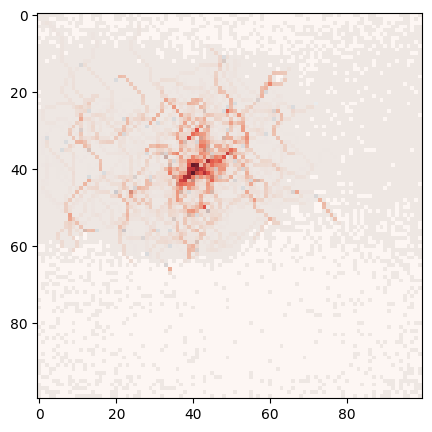

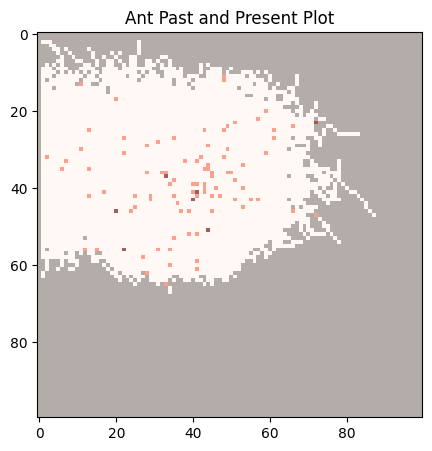

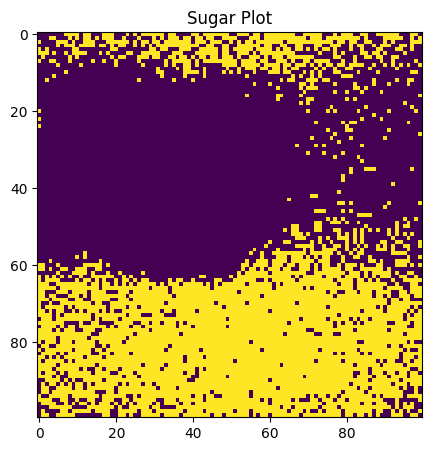

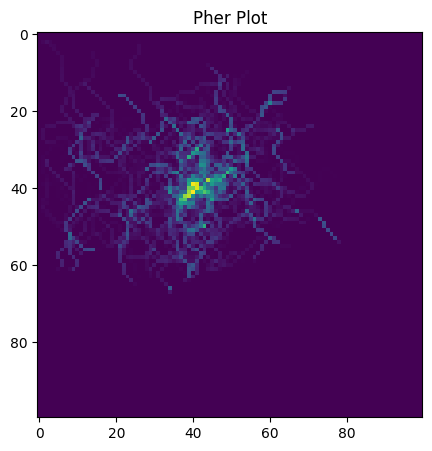

In [317]:
world.next_k_turns(5000)
world.hive_plots()

In [302]:
world.ants

[{'global_coord': [0, 0], 'mind': <__main__.AntMindOld at 0x1376ff760>}]

In [77]:
## TODO: add game of life's visualizing engine to this to make some nice gifts of the situation!
## TODO: more complicated pher drop detailed in notes so far below

### Notes So Far

I LOOOOOOVE the pher plot most of all. It's amazing to watch its time evolution. I'm wondering if it might be better to bring in a non-pandas piece to actually visualize (like using Processing and just having numpy arrays as inputs). 

The "GAME" is to define different params and see what your strategy looks like and how well it works! For example you can change the halflife of the pheromones, or the amount of weight you put on each direction. Both these changes how easily ants for example get trapped in a pheromone loop vs. go exploring.

I bet different strategies matter for time evolving fields, dense fields, sparse fields, etc. ant birth and death is interesting and you know, we could make it a function of sugar! like the more sugar the colony accumulates the more it can birth but it also needs to keep accumulating sugar or ants start to die. that would be really cool. 

anyways it might be time to clean this project up we've gone far. Just even doing a demo notebook (instead of this dev notebook) with movies of the ant movements vs. the sugar movements vs. the pher plots vs. the ants been here plots might be enough. (probably can layer ants been here vs. ant movements).


also another fun knob to add: try having it drop more phers when it has food! so that the return path home gets strengthened. to do this you might need to implement the local to global grid swap rather than having the ant just drop pher and pick up sugar.


### another fun plot

kde plot of ant density!

In [655]:
import scipy

In [658]:
test_hive.ant_grid.sum()

100.0

In [659]:
scipy.stats.gaussian_kde(test_hive.ant_grid) # might have to set my own kde filter, probably shouldn't be too hard, but unlikely to be worth the work for a pretty picture

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.